In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))

cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_ism[cesm_ism==0] = np.nan
cesm_ism[cesm_ism>0] = 1

lat = cesm_masks.lat.values
lon = cesm_masks.lon.values
cesm_ism2, lon2 = add_cyclic_point(cesm_ism, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [3]:
#CESM1 shortwave
CESM1_sw = xr.load_dataset('/glade/work/devond/CESM/radiation/CESM1lens_FSDS_hist2.nc')['FSDS']
CESM1_sw = CESM1_sw.mean(dim = 'ensemble').sel(time=slice("1979-01-01", "2015-01-01"))*cesm_ism

#CESM1 longwave
CESM1_lw = xr.load_dataset('/glade/work/devond/CESM/radiation/CESM1lens_FLDS_hist2.nc')['FLDS']
CESM1_lw = CESM1_lw.mean(dim = 'ensemble').sel(time=slice("1979-01-01", "2015-01-01"))*cesm_ism

#CESM2 shortwave
CESM2_sw = xr.load_dataset('/glade/work/devond/CESM/radiation/CESM2_FSDS_hist.nc')['FSDS']
CESM2_sw = CESM2_sw.sel(lat = slice(-90,-60))
CESM2_sw = CESM2_sw.mean(dim = 'ensemble').sel(time=slice("1979-01-01", "2015-01-01"))*cesm_ism

#CESM2 longwave
CESM2_lw = xr.load_dataset('/glade/work/devond/CESM/radiation/CESM2_FLDS_hist.nc')['FLDS']
CESM2_lw = CESM2_lw.sel(lat = slice(-90,-60))
CESM2_lw = CESM2_lw.mean(dim = 'ensemble').sel(time=slice("1979-01-01", "2015-01-01"))*cesm_ism


## CESM Radiation maps

In [4]:
CESM2_sw_annual = CESM2_sw.sel(time=CESM2_sw['time.season']=='DJF').mean(dim = 'time').values
CESM2_sw_annual, lon2 = add_cyclic_point(CESM2_sw_annual, coord=lon)

CESM1_sw_annual = CESM1_sw.sel(time=CESM1_sw['time.season']=='DJF').mean(dim = 'time').values
CESM1_sw_annual, lon2 = add_cyclic_point(CESM1_sw_annual, coord=lon)

CESM2_lw_annual = CESM2_lw.mean(dim = 'time').values
CESM2_lw_annual, lon2 = add_cyclic_point(CESM2_lw_annual, coord=lon)

CESM1_lw_annual = CESM1_lw.mean(dim = 'time').values
CESM1_lw_annual, lon2 = add_cyclic_point(CESM1_lw_annual, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


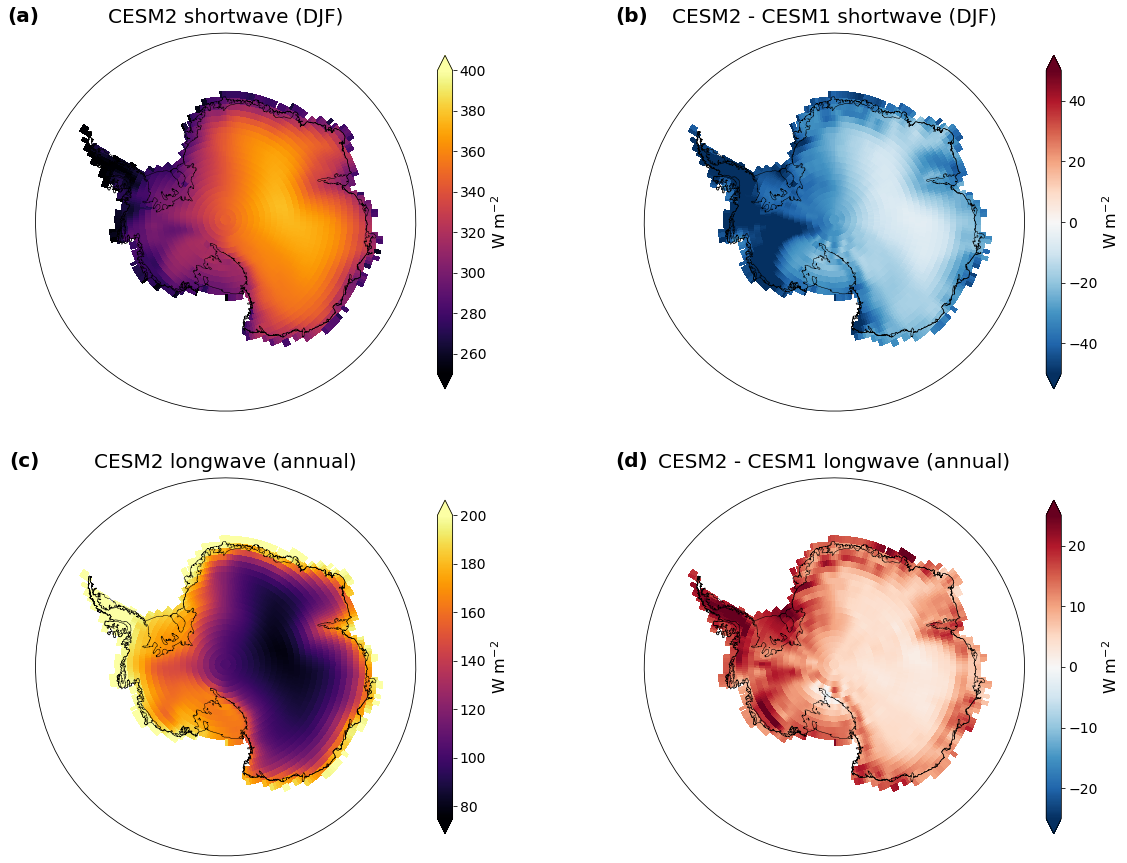

In [5]:
fig = plt.figure(figsize = (20,15))
gs=GridSpec(2,2)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0,0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, lat, CESM2_sw_annual*cesm_ism2, cmap = 'inferno',transform = crs_ll, vmin = 250,vmax = 400)
ax1.set_title('CESM2 shortwave (DJF)', fontsize = 20)
cb = plt.colorbar(im, shrink = 0.9, extend = 'both')
cb.set_label('W m$^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax1.text(0, 1.08, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0,1],projection=crs_sp)
plot_antarctica(ax2,-60)
im2 = ax2.pcolormesh(lon2, lat, (CESM2_sw_annual - CESM1_sw_annual)*cesm_ism2, cmap = 'RdBu_r',vmin= -50,vmax = 50,transform = crs_ll)
ax2.set_title('CESM2 - CESM1 shortwave (DJF)', fontsize = 20)
cb = plt.colorbar(im2, shrink = 0.9, extend = 'both')
cb.set_label('W m$^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax2.text(0, 1.08, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[1,0],projection=crs_sp)
plot_antarctica(ax3,-60)
im3 = ax3.pcolormesh(lon2, lat, CESM2_lw_annual*cesm_ism2, cmap = 'inferno',transform = crs_ll, vmin = 75,vmax = 200)
ax3.set_title('CESM2 longwave (annual)', fontsize = 20)
cb = plt.colorbar(im3, shrink = 0.9, extend = 'both')
cb.set_label('W m$^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax3.text(0, 1.08, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[1,1],projection=crs_sp)
plot_antarctica(ax4,-60)
im4 = ax4.pcolormesh(lon2, lat, (CESM2_lw_annual - CESM1_lw_annual)*cesm_ism2, cmap = 'RdBu_r',vmin= -25,vmax = 25,transform = crs_ll)
ax4.set_title('CESM2 - CESM1 longwave (annual)', fontsize = 20)
cb = plt.colorbar(im4, shrink = 0.9, extend = 'both')
cb.set_label('W m$^{-2}$', fontsize = 16)
cb.ax.tick_params(labelsize=14)
ax4.text(0, 1.08, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.savefig('radiation.png', dpi = 300, bbox_inches = 'tight', transparent = True)

## Radiation seasonality

In [17]:
cesm_area = cesm_masks.area.values

cesm2_lw_month = (CESM2_lw*cesm_area*cesm_ism).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm2_lw_month = cesm2_lw_month.groupby(cesm2_lw_month.time.dt.month).mean()#/10**9

cesm1_lw_month = (CESM1_lw*cesm_area*cesm_ism).sum(dim = ['lat','lon'])/np.nansum(cesm_area*cesm_ism)
cesm1_lw_month = cesm1_lw_month.groupby(cesm1_lw_month.time.dt.month).mean()#/10**9

lw_seasonal_bias = cesm2_lw_month - cesm1_lw_month

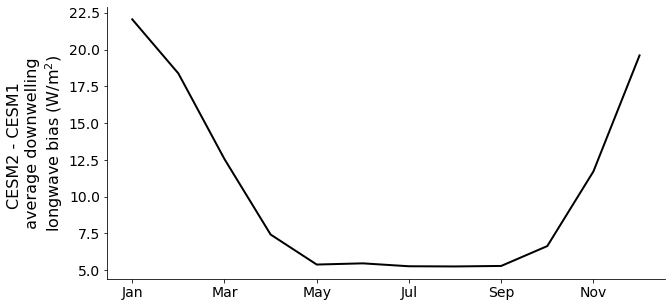

In [21]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(lw_seasonal_bias, color = 'black', linewidth = 2)
# ax.plot(cesm1_lw_month, color = 'olivedrab', linewidth = 2)
ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], fontsize = 16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=14)
ax.set_ylabel('CESM2 - CESM1 \n average downwelling \nlongwave bias (W/m$^2$)', fontsize=16)

plt.savefig('radiation_seasonal_bias.png', dpi = 300, bbox_inches = 'tight')